In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Learner v2


## Data

In [3]:
#export
from exp.nb_10 import *

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160) # downloads and returns a path to folder
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor] # transforms to be applied to images
bs = 128
il = ImageList.from_files(path, tfms=tfms) # Imagelist of filenames from path
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name="val")) # Splitdata by folder function
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcesser()) # label the data by parent folder
data = ll.to_databunch(bs, c_in=3, c_out=10)

In [5]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
nfs = [32]*4

 ## New Learner

In [7]:
#export
def param_getter(m):
    return m.parameters()

Our new `Learner` will contain basically everything we need to train a model: data, a model, an optimizer, a learning rate, and callbacks.

The `Learner` is now the central container but also runs all  of the modular components in a certain sequence. This gives us an overarching framework to combine and customize our modular parts. 



In [15]:
#export
class Learner():
    
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter, cbs=None, cb_funcs=None):
        
        # store components
        self.model = model
        self.data = data
        self.loss_func = loss_func
        self.opt_func = opt_func
        self.lr = lr 
        self.splitter = splitter

        # state
        self.in_train = False
        
        # logging
        self.logger = print
        
        # ??
        self.opt = None
        
        # callbacks
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))
    
    
    ##### callback methods ##### 
    
    def add_cbs(self, cbs): 
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)
        
    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    ####### Training Loop ########
    
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
            
        except CancelBatchException:                        self('after_cancel_batch')
            
        finally:                                            self('after_batch')
            
    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i, (xb, yb) in enumerate(self.dl): 
                self.one_batch(i, xb, yb)
        
        except CancelEpochException:                        self('after_cancel_epoch')
        
    
    def do_begin_fit(self, epochs):
        self.epochs, self.loss = epochs, tensor(0.)
        self('begin_fit')
    
    def do_begin_epoch(self, epoch):
        self.epoch, self.dl = epoch, self.data.train_dl
        return self('begin_epoch')
    
    def fit(self, epochs, cbs=None, reset_opt=False):
        # callbacks passed to fit
        self.add_cbs(cbs)
        
        # allows for freezing and unfreezing parameters ??
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        
        try:
            self.do_begin_fit(epochs)
            
            for epoch in range(epochs):
                if not self.do_begin_epoch(epoch): self.all_batches()
                
                with torch.no_grad():
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
                    
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs) # remove cbs passed to fit
            
    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

## Refactor Callbacks

`AvgStatsCallback`

In [16]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)

    def after_epoch(self):
        self.logger(self.train_stats)
        self.logger(self.valid_stats)

In [17]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback, 
       partial(BatchTransformXCallback, norm_imagenette)]

## Testing

In [18]:
#export
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [19]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [20]:
%time learn.fit(1)

Train: [1.8443, 0.3593]
Valid: [1.6559, 0.4311]



Let's add in our `Recorder` to make sure its compatible with our new `Learner`

In [22]:
cbfs += [Recorder]

In [23]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [25]:
phases = combine_scheds([0.4, 0.6], [sched_exp(0.2, 0.8), sched_cos(0.8, 0.1)])

In [28]:
sched = ParamScheduler('lr', phases)

In [29]:
%time learn.fit(3, cbs=sched)

Train: [1.9314, 0.3184]
Valid: [1.8059, 0.3952]

Train: [1.5947, 0.4569]
Valid: [1.5987, 0.469]

Train: [1.2309, 0.5841]
Valid: [1.2626, 0.5837]

Wall time: 51.8 s


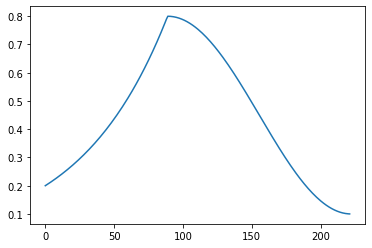

In [30]:
learn.recorder.plot_lr()

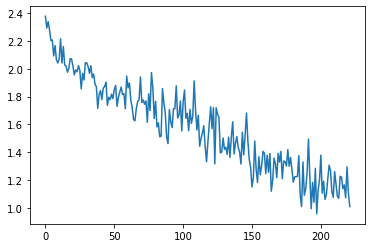

In [31]:
learn.recorder.plot_loss()

# Progress Bar

In [33]:
#export
import time
from time import sleep
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

### Fastprogress Examples

In order to make a proper progress bar.

In [38]:
mb = master_bar(range(10))

for i in mb:
    for j in progress_bar(range(100), parent=mb):
        sleep(0.01)
        mb.child.comment = f'second bar stat'
    mb.main_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')

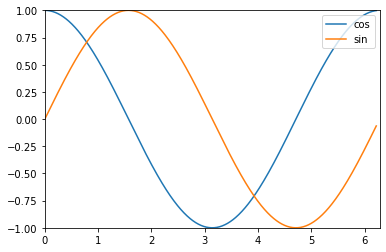

In [40]:
import numpy as np
mb = master_bar(range(10))
mb.names = ['cos', 'sin']
for i in mb:
    for j in progress_bar(range(100), parent=mb):
        if j%10 == 0:
            k = 100 * i + j
            x = np.arange(0, 2*k*np.pi/1000, 0.01)
            y1, y2 = np.cos(x), np.sin(x)
            graphs = [[x,y1], [x,y2]]
            x_bounds = [0, 2*np.pi]
            y_bounds = [-1,1]
            mb.update_graph(graphs, x_bounds, y_bounds)
            mb.child.comment = f'second bar stat'
    mb.main_bar.comment = f'first bar stat'
    mb.write(f'Finished loop {i}.')

### AvgStatsCallback

In [47]:
AvgStats??

In [48]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)
        
    def begin_fit(self):
        metric_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['Epoch'] + [f'train_{n}' for n in metric_names] + [
            f'valid_{n}' for n in metric_names] + ['time']
        self.logger(names)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)

    def after_epoch(self):
        stats = [str(self.epoch)]
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats]
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)


### ProgressCallback

In [49]:
#export
class ProgressCallback(Callback):
    _order = -1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.run.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self): self.mbar.on_iter_end()
    def after_batch(self): self.pb.update(self.iter)
    def begin_epoch   (self): self.set_pb()
    def begin_validate(self): self.set_pb()
        
    def set_pb(self):
        self.pb = progress_bar(self.dl, parent=self.mbar)
        self.mbar.update(self.epoch)

In [50]:
cbfs = [partial(AvgStatsCallback, accuracy),
       CudaCallback, 
       ProgressCallback, 
       partial(BatchTransformXCallback, norm_imagenette)]

In [51]:
learn = get_learner(nfs, data, 0.3, conv_layer, cb_funcs=cbfs)

In [52]:
learn.fit(2)

Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.927281,0.321470,1.778402,0.395159,00:14
1,1.575256,0.458127,1.513095,0.476943,00:14


In [53]:
nb_auto_export()

<IPython.core.display.Javascript object>